In [1]:
from Functions2 import *
from DataDefined2 import *
import torch
from torch import optim
torch.manual_seed(42)

df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')

# Out-of-distribution class
CLASS_OOD = 1

In [2]:
# Dropping columns
columns_to_drop = one_val_col + irrelevant_col
df = df.drop(columns_to_drop, axis=1)

# Adding columns
df = addRideNumbers(df)

In [3]:
for driver_class in sorted(df['Class'].unique()):
    driver_data = df[df['Class'] == driver_class]
    ride_counts = driver_data['Ride number'].unique()
    print(f"Ride number for Class {driver_class}: {ride_counts}")

Ride number for Class A: [1 2 3 4]
Ride number for Class B: [1 2 3 4 5 6]
Ride number for Class C: [1 2 3 4]
Ride number for Class D: [1 2 3 4 5 6]
Ride number for Class E: [1 2 3 4]
Ride number for Class F: [1 2 3 4]
Ride number for Class G: [1 2 3 4]
Ride number for Class H: [1 2 3 4]
Ride number for Class I: [1 2 3 4]
Ride number for Class J: [1 2 3 4]


In [4]:
# Encode the class first, as this cannot be encoded after the train-test-split, due to being out-of-distribution
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

In [5]:
### Add derivatives
df = add_delta(df, delta_col)

In [6]:
train_df, test_df = split_train_test_ood(df, CLASS_OOD, frac=0.15)

# Normalize
columns_to_scale = numerical_col + two_val_col
train_df, test_df = normalize_data(train_df, test_df, columns_to_scale)
# Encode
train_df, test_df = label_encode(train_df, test_df, categorical_col)

print("Classes in train:", len(train_df['Class'].unique()))
print("Classes in test:", len(test_df['Class'].unique()))

# Convert to input for the model
X_train = torch.tensor(train_df[numerical_col + ['Indication_of_brake_switch_ON/OFF']].values, dtype=torch.float32)
X_test = torch.tensor(test_df[numerical_col + ['Indication_of_brake_switch_ON/OFF']].values, dtype=torch.float32)

y_train = torch.tensor(train_df['Class'].values, dtype=torch.long)
y_test = torch.tensor(test_df['Class'].values, dtype=torch.long)

# (can be used for some OOD models)
ood_data = df[df['Class'] == CLASS_OOD]
X_ood = torch.tensor(ood_data[numerical_col + ['Indication_of_brake_switch_ON/OFF']].values, dtype=torch.long)
print('X_OOD:', X_ood.shape)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

# To evaluate, the OOD prediction should be compared
# Therefore, change class number that is OOD in the testset to -1
y_test_ood = torch.where(y_test == CLASS_OOD, -1, y_test)

Classes in train: 9
Classes in test: 10
X_OOD: torch.Size([12864, 35])
X_train: torch.Size([69288, 35])
X_test: torch.Size([25092, 35])
y_train: torch.Size([69288])
y_test: torch.Size([25092])


In [63]:
input_dim = X_train.shape[1]   
model = TabularNN(input_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classifications
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500

In [64]:
X_train.shape

torch.Size([69288, 35])

In [65]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Confusion matrix
# conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
# plt.figure(figsize=(10,7))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
#             xticklabels= ['-1 (OOD)',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'], 
#             yticklabels= ['B',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'])
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.title('Confusion Matrix with OOD Handling')
# plt.show()

In [66]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)  # Logits output
    loss = criterion(predictions, y_train)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)  # Logits
    # Convert logits to probabilities (using softmax) and get predicted class
    predicted_probs = torch.softmax(test_predictions, dim=1)
    max_probs, predicted_classes = torch.max(predicted_probs, dim=1)
    threshold = 0.65
    predicted_classes[max_probs < threshold] = -1  

# Normally, one would also calculate the test loss; however, now we have prediction -1, 
# so not sure how to handle that in the loss calculation 
print("Predicted Classes (with OOD detection):", predicted_classes)


Epoch 0, Loss: 2.3325
Epoch 10, Loss: 2.2666
Epoch 20, Loss: 2.1994
Epoch 30, Loss: 2.1254
Epoch 40, Loss: 2.0410
Epoch 50, Loss: 1.9394
Epoch 60, Loss: 1.8214
Epoch 70, Loss: 1.7032
Epoch 80, Loss: 1.5968
Epoch 90, Loss: 1.5082
Epoch 100, Loss: 1.4365
Epoch 110, Loss: 1.3784
Epoch 120, Loss: 1.3307
Epoch 130, Loss: 1.2908
Epoch 140, Loss: 1.2559
Epoch 150, Loss: 1.2234
Epoch 160, Loss: 1.1912
Epoch 170, Loss: 1.1584
Epoch 180, Loss: 1.1250
Epoch 190, Loss: 1.0904
Epoch 200, Loss: 1.0546
Epoch 210, Loss: 1.0187
Epoch 220, Loss: 0.9841
Epoch 230, Loss: 0.9508
Epoch 240, Loss: 0.9190
Epoch 250, Loss: 0.8891
Epoch 260, Loss: 0.8607
Epoch 270, Loss: 0.8340
Epoch 280, Loss: 0.8085
Epoch 290, Loss: 0.7843
Epoch 300, Loss: 0.7615
Epoch 310, Loss: 0.7401
Epoch 320, Loss: 0.7198
Epoch 330, Loss: 0.7007
Epoch 340, Loss: 0.6825
Epoch 350, Loss: 0.6653
Epoch 360, Loss: 0.6490
Epoch 370, Loss: 0.6335
Epoch 380, Loss: 0.6187
Epoch 390, Loss: 0.6045
Epoch 400, Loss: 0.5910
Epoch 410, Loss: 0.5782
Epo

In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_ood, predicted_classes)
print(cm)

[[4658   38  173 3658  522  388  127 1173  727 1400]
 [  56 1020    4    0    0    0    2    0    1    3]
 [ 326    0  748   29    0    9    4    8    1    0]
 [ 520    0   20 1398    3   24    8   14    0    0]
 [  14    0    2    0 1248    0    0    0    0    1]
 [ 504    1    6   23    1 1088    7   16    1    5]
 [ 384    8    4   34    0   16  646   12   20    0]
 [ 644    1    2    1    3   20    1  739   24   47]
 [ 662    2    5    0    0    1    5   68  383   45]
 [ 745    1    3    6    6    7    0   49   35  484]]


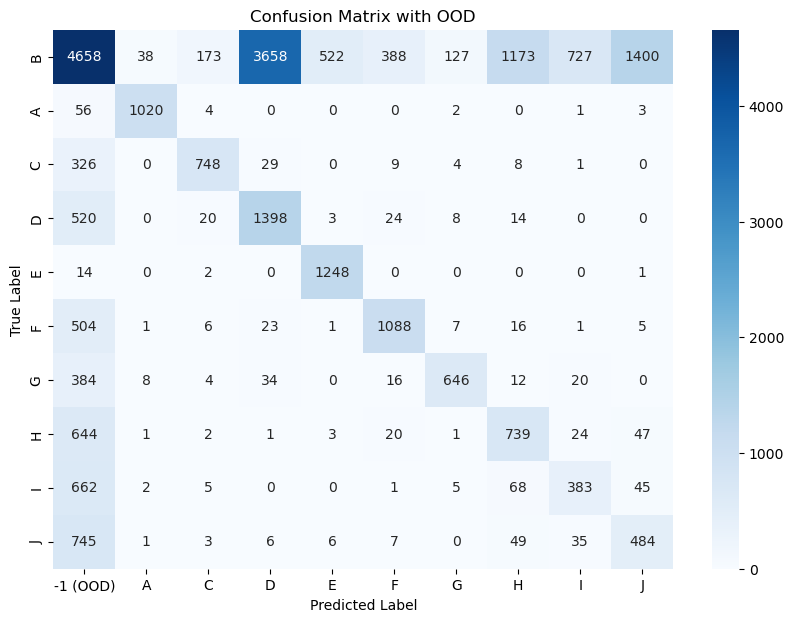

In [68]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_ood, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels= ['-1 (OOD)',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'], 
            yticklabels= ['B',  'A',  'C',  'D',  'E',  'F',  'G',  'H',  'I',  'J'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix with OOD')
plt.show()

In [69]:
print(classification_report(y_test_ood, predicted_classes))

              precision    recall  f1-score   support

          -1       0.55      0.36      0.44     12864
           0       0.95      0.94      0.95      1086
           2       0.77      0.66      0.72      1125
           3       0.27      0.70      0.39      1987
           4       0.70      0.99      0.82      1265
           5       0.70      0.66      0.68      1652
           6       0.81      0.57      0.67      1124
           7       0.36      0.50      0.42      1482
           8       0.32      0.33      0.32      1171
           9       0.24      0.36      0.29      1336

    accuracy                           0.49     25092
   macro avg       0.57      0.61      0.57     25092
weighted avg       0.54      0.49      0.50     25092



In [28]:
print(X_train.shape)
print(ood_data.shape)

torch.Size([69288, 35])
torch.Size([12864, 35])
